In [1]:
import os
import glob
import cv2
import tifffile
import numpy as np
import random

# ----------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------
PATCH_SIZE = 256
STRIDE = PATCH_SIZE
TRAIN_SPLIT_RATIO = 0.75  # 75% images go to train, 25% to test

# --- Input (original) dataset ---
ORIG_DATA_DIR = "/Users/celinewu/Documents/2024_dataset"
IMG_DIR = os.path.join(ORIG_DATA_DIR, "images")
MASK_DIR = os.path.join(ORIG_DATA_DIR, "masks")

# --- Output (processed) dataset ---
OUT_DATA_DIR = "/Users/celinewu/Documents/Processed_2024DS"

# Subfolders for images
OUT_IMG_TRAIN = os.path.join(OUT_DATA_DIR, "images", "train")
OUT_IMG_TEST  = os.path.join(OUT_DATA_DIR, "images", "test")

# Subfolders for masks
OUT_MASK_TRAIN = os.path.join(OUT_DATA_DIR, "masks", "train")
OUT_MASK_TEST  = os.path.join(OUT_DATA_DIR, "masks", "test")

os.makedirs(OUT_IMG_TRAIN, exist_ok=True)
os.makedirs(OUT_IMG_TEST, exist_ok=True)
os.makedirs(OUT_MASK_TRAIN, exist_ok=True)
os.makedirs(OUT_MASK_TEST, exist_ok=True)

def pad_to_multiple(img, multiple=256, border_mode=cv2.BORDER_REFLECT):
    """
    Pads 'img' so that its dimensions are multiples of 'multiple'.
    Returns the padded image (NumPy array).
    By default, uses REFLECT border mode for padding.
    """
    h, w = img.shape[:2]
    pad_h = (multiple - (h % multiple)) if (h % multiple) != 0 else 0
    pad_w = (multiple - (w % multiple)) if (w % multiple) != 0 else 0
    
    padded_img = cv2.copyMakeBorder(
        img,
        0, pad_h,
        0, pad_w,
        border_mode
    )
    return padded_img

def split_into_patches(img, patch_size=256, stride=256):
    """
    Splits the padded 'img' into patches of size patch_size×patch_size.
    Returns a list of patches (NumPy arrays).
    """
    h, w = img.shape[:2]
    patches = []
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
    return patches

def process_dataset_by_image():
    """
    1) Gather all image filenames
    2) Randomly split them into train (75%) and test (25%) at IMAGE level
    3) For each image, read image and 3 masks, pad, patch
    4) Save all patches (image + masks) to either train or test subfolders
    """

    # 1) Gather all PNG images in the original dataset
    image_paths = glob.glob(os.path.join(IMG_DIR, "*.png"))
    image_paths.sort()  # optional, if you want stable ordering
    
    # 2) Randomly shuffle, then split at the image level
    random.shuffle(image_paths)
    
    num_images = len(image_paths)
    train_count = int(num_images * TRAIN_SPLIT_RATIO)
    train_image_paths = image_paths[:train_count]
    test_image_paths  = image_paths[train_count:]
    
    print(f"Total images: {num_images}")
    print(f"Train images: {len(train_image_paths)}")
    print(f"Test images:  {len(test_image_paths)}")
    
    # Helper functions for saving
    def save_image_patch(patch, out_path):
        cv2.imwrite(out_path, patch)
    
    def save_mask_patch(patch, out_path):
        tifffile.imwrite(out_path, patch)

    # 3) Define a function that processes one image (and saves to train or test)
    def process_one_image(img_path, is_train=True):
        """
        Reads one image, finds matching root/shoot/seed masks, pads, splits into patches,
        saves all patches to the correct subfolder (train or test).
        """
        base_name = os.path.basename(img_path)             # e.g. "train_Alican_230858_im3.png"
        file_no_ext = os.path.splitext(base_name)[0]       # e.g. "train_Alican_230858_im3"
        
        # Build corresponding mask paths
        root_path  = os.path.join(MASK_DIR, f"{file_no_ext}_root_mask.tif")
        shoot_path = os.path.join(MASK_DIR, f"{file_no_ext}_shoot_mask.tif")
        seed_path  = os.path.join(MASK_DIR, f"{file_no_ext}_seed_mask.tif")

        # (a) Read the image
        img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img_bgr is None:
            print(f"[ERROR] Cannot read image: {img_path}")
            return

        # (b) Read the masks if they exist
        mask_root  = tifffile.imread(root_path) if os.path.exists(root_path) else None
        mask_shoot = tifffile.imread(shoot_path) if os.path.exists(shoot_path) else None
        mask_seed  = tifffile.imread(seed_path) if os.path.exists(seed_path) else None
        
        if mask_root is None:
            print(f"[WARNING] Missing root mask for: {file_no_ext}")
        if mask_shoot is None:
            print(f"[WARNING] Missing shoot mask for: {file_no_ext}")
        if mask_seed is None:
            print(f"[WARNING] Missing seed mask for: {file_no_ext}")
        
        # (c) Pad image & masks
        padded_img = pad_to_multiple(img_bgr, PATCH_SIZE, cv2.BORDER_REFLECT)
        
        if mask_root is not None:
            padded_root = pad_to_multiple(mask_root, PATCH_SIZE, cv2.BORDER_REFLECT)
        else:
            padded_root = None
        
        if mask_shoot is not None:
            padded_shoot = pad_to_multiple(mask_shoot, PATCH_SIZE, cv2.BORDER_REFLECT)
        else:
            padded_shoot = None
        
        if mask_seed is not None:
            padded_seed = pad_to_multiple(mask_seed, PATCH_SIZE, cv2.BORDER_REFLECT)
        else:
            padded_seed = None
        
        # (d) Split into patches
        img_patches = split_into_patches(padded_img, PATCH_SIZE, STRIDE)
        root_patches  = split_into_patches(padded_root,  PATCH_SIZE, STRIDE) if padded_root  is not None else [None]*len(img_patches)
        shoot_patches = split_into_patches(padded_shoot, PATCH_SIZE, STRIDE) if padded_shoot is not None else [None]*len(img_patches)
        seed_patches  = split_into_patches(padded_seed,  PATCH_SIZE, STRIDE) if padded_seed  is not None else [None]*len(img_patches)
        
        # (e) Determine output folders (train or test)
        if is_train:
            out_img_folder  = OUT_IMG_TRAIN
            out_mask_folder = OUT_MASK_TRAIN
        else:
            out_img_folder  = OUT_IMG_TEST
            out_mask_folder = OUT_MASK_TEST
        
        # (f) Save each patch
        for idx, img_patch in enumerate(img_patches):
            # Example patch name for the image
            patch_name_img   = f"{file_no_ext}_{idx}.png"
            # For masks
            patch_name_root  = f"{file_no_ext}_root_mask_{idx}.tif"
            patch_name_shoot = f"{file_no_ext}_shoot_mask_{idx}.tif"
            patch_name_seed  = f"{file_no_ext}_seed_mask_{idx}.tif"
            
            # Save the image patch
            out_img_path = os.path.join(out_img_folder, patch_name_img)
            save_image_patch(img_patch, out_img_path)
            
            # Save root/shoot/seed patches if they exist
            if root_patches[idx] is not None:
                out_root_path = os.path.join(out_mask_folder, patch_name_root)
                save_mask_patch(root_patches[idx], out_root_path)
            if shoot_patches[idx] is not None:
                out_shoot_path = os.path.join(out_mask_folder, patch_name_shoot)
                save_mask_patch(shoot_patches[idx], out_shoot_path)
            if seed_patches[idx] is not None:
                out_seed_path = os.path.join(out_mask_folder, patch_name_seed)
                save_mask_patch(seed_patches[idx], out_seed_path)
        
        print(f"[OK] Completed patches for {base_name} -> {'train' if is_train else 'test'} folder.")
    
    # Process all images in the train list
    for img_path in train_image_paths:
        process_one_image(img_path, is_train=True)
    
    # Process all images in the test list
    for img_path in test_image_paths:
        process_one_image(img_path, is_train=False)
    
    print("All done! Your images are split at the **image level**:")
    print(f" - {OUT_IMG_TRAIN}, {OUT_IMG_TEST} for image patches")
    print(f" - {OUT_MASK_TRAIN}, {OUT_MASK_TEST} for mask patches")
    print("Original dataset is untouched.")


if __name__ == "__main__":
    process_dataset_by_image()


Total images: 450
Train images: 337
Test images:  113
[WARNING] Missing root mask for: train_Dean_226324_im4
[WARNING] Missing shoot mask for: train_Dean_226324_im4
[WARNING] Missing seed mask for: train_Dean_226324_im4
[OK] Completed patches for train_Dean_226324_im4.png -> train folder.
[WARNING] Missing root mask for: val_Jason_234041_im3
[WARNING] Missing shoot mask for: val_Jason_234041_im3
[WARNING] Missing seed mask for: val_Jason_234041_im3
[OK] Completed patches for val_Jason_234041_im3.png -> train folder.
[OK] Completed patches for train_Shival_231781_im4.png -> train folder.
[WARNING] Missing root mask for: val_Jason_234450_im5
[WARNING] Missing shoot mask for: val_Jason_234450_im5
[WARNING] Missing seed mask for: val_Jason_234450_im5
[OK] Completed patches for val_Jason_234450_im5.png -> train folder.
[OK] Completed patches for train_Elavendan_231709_im5.png -> train folder.
[WARNING] Missing root mask for: val_Jason_234301_im1
[WARNING] Missing shoot mask for: val_Jason_2

In [16]:
import os
import glob

def remove_images_with_no_masks(images_dir, masks_dir):
    """
    For each *.png in 'images_dir', checks if the corresponding
    root/shoot/seed *.tif files exist in 'masks_dir'.
    If *all three* are missing, deletes the image file.
    """
    image_paths = glob.glob(os.path.join(images_dir, "*.png"))
    print(f"Checking {len(image_paths)} patches in '{images_dir}'...")

    for image_path in image_paths:
        image_name = os.path.basename(image_path)
        base_name = os.path.splitext(image_name)[0]
        # Example: base_name = "train_Alican_230858_im3_0"

        # Split off the last underscore to get prefix/suffix
        # e.g. prefix="train_Alican_230858_im3", suffix="0"
        idx = base_name.rfind("_")
        prefix = base_name[:idx]
        suffix = base_name[idx+1:]

        # Construct the expected mask filenames
        root_mask_path = os.path.join(masks_dir, f"{prefix}_root_mask_{suffix}.tif")
        shoot_mask_path = os.path.join(masks_dir, f"{prefix}_shoot_mask_{suffix}.tif")
        seed_mask_path = os.path.join(masks_dir, f"{prefix}_seed_mask_{suffix}.tif")

        # Check if any of these files exist
        root_exists  = os.path.exists(root_mask_path)
        shoot_exists = os.path.exists(shoot_mask_path)
        seed_exists  = os.path.exists(seed_mask_path)

        # If all three are missing, remove the image patch
        if not (root_exists or shoot_exists or seed_exists):
            print(f"  Deleting {image_name} because no mask files were found.")
            os.remove(image_path)

# ----------------------------------------------------------------
# Run for both "train" and "test" folders
# ----------------------------------------------------------------
processed_ds = "/Users/celinewu/Documents/Processed_2024DS"

train_img_dir = os.path.join(processed_ds, "images", "train")
train_mask_dir = os.path.join(processed_ds, "masks", "train")

test_img_dir = os.path.join(processed_ds, "images", "test")
test_mask_dir = os.path.join(processed_ds, "masks", "test")

# Remove unmatched image patches in train
remove_images_with_no_masks(train_img_dir, train_mask_dir)
# Remove unmatched image patches in test
remove_images_with_no_masks(test_img_dir, test_mask_dir)

print("Done cleaning up image patches without corresponding masks.")


Checking 68748 patches in '/Users/celinewu/Documents/Processed_2024DS/images/train'...
  Deleting val_Jason_234301_im4_102.png because no mask files were found.
  Deleting train_Shival_231265_im1_145.png because no mask files were found.
  Deleting train_Dean_231541_im2_202.png because no mask files were found.
  Deleting train_Karna_236495_im1_192.png because no mask files were found.
  Deleting val_Jason_234450_im3_31.png because no mask files were found.
  Deleting val_Jason_234450_im5_200.png because no mask files were found.
  Deleting val_Myrthe_230302_im3_80.png because no mask files were found.
  Deleting train_Shival_230306_im1_12.png because no mask files were found.
  Deleting val_Myrthe_213041_im1_48.png because no mask files were found.
  Deleting val_Myrthe_230302_im4_89.png because no mask files were found.
  Deleting val_Jason_234838_im2_75.png because no mask files were found.
  Deleting val_Jason_225739_im5_66.png because no mask files were found.
  Deleting val_Jason

In [20]:
import random
import os
import cv2
import tifffile
import matplotlib.pyplot as plt

TRAIN_IMG_DIR = "/Users/celinewu/Documents/Processed_2024DS/images/train"
TRAIN_MASK_DIR = "/Users/celinewu/Documents/Processed_2024DS/masks/train"

# list all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
if not image_patches:
    print("No train patches found.")
else:
    rand_patch_name = random.choice(image_patches)  # e.g. train_Alican_230858_im3_0.png
    print("Random image patch:", rand_patch_name)
    
    # load image
    img_path = os.path.join(TRAIN_IMG_DIR, rand_patch_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # try root mask
    base_no_ext = os.path.splitext(rand_patch_name)[0]  # e.g. train_Alican_230858_im3_0
    root_mask_name  = base_no_ext + "_root_mask.tif"
    root_mask_path  = os.path.join(TRAIN_MASK_DIR, root_mask_name)
    if os.path.exists(root_mask_path):
        root_mask = tifffile.imread(root_mask_path)
        overlay = img_rgb.copy()
        overlay[root_mask > 0] = [255, 0, 0]  # highlight in red
        blended = cv2.addWeighted(img_rgb, 0.6, overlay, 0.4, 0)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(img_rgb)
        axs[0].set_title("Image Patch")
        axs[1].imshow(root_mask, cmap='gray')
        axs[1].set_title("Root Mask")
        axs[2].imshow(blended)
        axs[2].set_title("Overlay (root in red)")
        for ax in axs:
            ax.axis('off')
        plt.show()
    else:
        print("No root mask found for this patch.")


Random image patch: train_Shival_231265_im2_155.png
No root mask found for this patch.


Random image patch: val_Myrthe_231999_im5_76.png
Looking for root mask at: /Users/celinewu/Documents/Processed_2024DS/masks/train/val_Myrthe_231999_im5_root_mask_76.tif
Looking for shoot mask at: /Users/celinewu/Documents/Processed_2024DS/masks/train/val_Myrthe_231999_im5_shoot_mask_76.tif
Looking for seed mask at: /Users/celinewu/Documents/Processed_2024DS/masks/train/val_Myrthe_231999_im5_seed_mask_76.tif


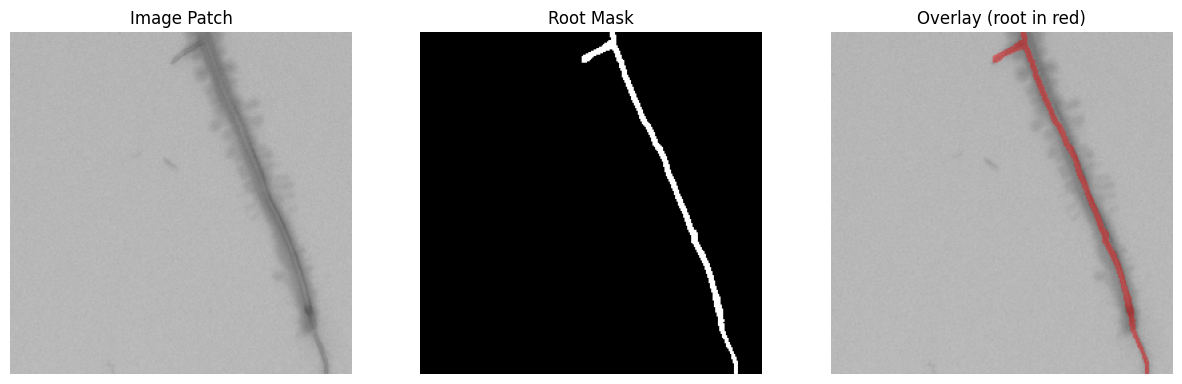

In [143]:
import random
import os
import cv2
import tifffile
import matplotlib.pyplot as plt

TRAIN_IMG_DIR = "/Users/celinewu/Documents/Processed_2024DS/images/train"
TRAIN_MASK_DIR = "/Users/celinewu/Documents/Processed_2024DS/masks/train"

# List all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
if not image_patches:
    print("No train patches found.")
else:
    rand_patch_name = random.choice(image_patches)  # e.g. train_Dean_231667_im1_23.png
    print("Random image patch:", rand_patch_name)
    
    # Load image
    img_path = os.path.join(TRAIN_IMG_DIR, rand_patch_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Construct mask filenames based on the correct naming convention
    base_no_ext = os.path.splitext(rand_patch_name)[0]  # e.g. train_Dean_231667_im1_23
    base_parts = base_no_ext.rsplit("_", 1)  # Split into ["train_Dean_231667_im1", "23"]
    mask_base = base_parts[0]  # "train_Dean_231667_im1"
    patch_index = base_parts[1]  # "23"
    
    # Construct mask filenames
    root_mask_name  = f"{mask_base}_root_mask_{patch_index}.tif"
    shoot_mask_name = f"{mask_base}_shoot_mask_{patch_index}.tif"
    seed_mask_name  = f"{mask_base}_seed_mask_{patch_index}.tif"
    
    root_mask_path  = os.path.join(TRAIN_MASK_DIR, root_mask_name)
    shoot_mask_path = os.path.join(TRAIN_MASK_DIR, shoot_mask_name)
    seed_mask_path  = os.path.join(TRAIN_MASK_DIR, seed_mask_name)
    
    # Debugging paths
    print("Looking for root mask at:", root_mask_path)
    print("Looking for shoot mask at:", shoot_mask_path)
    print("Looking for seed mask at:", seed_mask_path)
    
    # Check if root mask exists and display
    if os.path.exists(root_mask_path):
        root_mask = tifffile.imread(root_mask_path)
        overlay = img_rgb.copy()
        overlay[root_mask > 0] = [255, 0, 0]  # Highlight root mask in red
        blended = cv2.addWeighted(img_rgb, 0.6, overlay, 0.4, 0)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(img_rgb)
        axs[0].set_title("Image Patch")
        axs[1].imshow(root_mask, cmap='gray')
        axs[1].set_title("Root Mask")
        axs[2].imshow(blended)
        axs[2].set_title("Overlay (root in red)")
        for ax in axs:
            ax.axis('off')
        plt.show()
    else:
        print(f"No root mask found for this patch: {rand_patch_name}")
